In [2]:
import pandas as pd

In [3]:
import numpy as np
import seaborn as sns                       
import matplotlib.pyplot as plt
from scipy import stats

In [4]:
# loading datasets

customers = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/customers_final.csv')
engagement = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/engagements_final.csv')
marketing = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/marketing_final.csv')
transactions = pd.read_csv('https://raw.githubusercontent.com/delinai/schulich_ds1_2024/main/Datasets/transactions_final.csv')

In [5]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   customer_id         10000 non-null  int64  
 1   join_date           10000 non-null  object 
 2   last_purchase_date  10000 non-null  object 
 3   age                 8991 non-null   float64
 4   gender              9467 non-null   object 
 5   location            10000 non-null  object 
dtypes: float64(1), int64(1), object(4)
memory usage: 468.9+ KB


In [6]:
engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   customer_id              10000 non-null  int64
 1   number_of_site_visits    10000 non-null  int64
 2   number_of_emails_opened  10000 non-null  int64
 3   number_of_clicks         10000 non-null  int64
dtypes: int64(4)
memory usage: 312.6 KB


In [7]:
marketing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25200 entries, 0 to 25199
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   campaign_id     25200 non-null  int64 
 1   customer_id     25200 non-null  int64 
 2   response        25200 non-null  object
 3   promotion_type  25200 non-null  object
 4   campaign_date   25200 non-null  object
dtypes: int64(2), object(3)
memory usage: 984.5+ KB


In [8]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 129545 entries, 0 to 129544
Data columns (total 5 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   transaction_id      129545 non-null  int64  
 1   customer_id         129545 non-null  int64  
 2   transaction_date    129545 non-null  object 
 3   transaction_amount  129545 non-null  float64
 4   product_category    129545 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 4.9+ MB


In [9]:
# DATA CLEANING

# Handle missing values
customers['age'] = customers['age'].fillna(customers['age'].mean())
customers['gender'] = customers['gender'].fillna('Unknown')


In [10]:
# Convert date columns to datetime
customers['join_date'] = pd.to_datetime(customers['join_date'])
customers['last_purchase_date'] = pd.to_datetime(customers['last_purchase_date'])
transactions['transaction_date'] = pd.to_datetime(transactions['transaction_date'])
marketing['campaign_date'] = pd.to_datetime(marketing['campaign_date'])


In [11]:
# step 1: make transactions and marketing indexes as customer_id for easy joining
customers.set_index('customer_id', inplace=True)
transactions.set_index('customer_id', inplace=True)
marketing.set_index('customer_id', inplace=True)
engagement.set_index('customer_id', inplace=True)

In [12]:
#joining first 3 tables

transaction_level = customers.join(engagement).join(transactions)
transaction_level.head(5)

,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
customer_id,,,,,,,,,,,,
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics


In [13]:
transaction_level.reset_index(inplace=True)

In [14]:
marketing.reset_index(inplace=True)

In [15]:
# merge function we'll use requires sorting
transaction_level.sort_values(by=['customer_id','transaction_date'], inplace=True)
marketing.sort_values(by=['customer_id','campaign_date'], inplace=True)

In [16]:
# Custom function to find the most recent campaign before each transaction
def find_previous_campaign(transaction_row, campaigns):
    customer_campaigns = campaigns[campaigns['customer_id'] == transaction_row['customer_id']]
    customer_campaigns = customer_campaigns[customer_campaigns['campaign_date'] <= transaction_row['transaction_date']]
    if not customer_campaigns.empty:
        return customer_campaigns.iloc[-1]  # Return the most recent campaign
    else:
        return pd.Series([None] * campaigns.shape[1], index=campaigns.columns)

# Apply the custom function to each transaction
matched_campaigns = transaction_level.apply(find_previous_campaign, axis=1, campaigns=marketing)

# Merge the matched campaigns with transactions
df_merged = transaction_level.join(matched_campaigns.add_prefix('campaign_'))

In [17]:
# check merged data
df_merged[df_merged['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category,campaign_customer_id,campaign_campaign_id,campaign_response,campaign_promotion_type,campaign_campaign_date
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing,NaN,NaN,None,None,NaT
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics,1.0,4.0,Yes,Buy One Get One,2024-01-10
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing,1.0,2.0,No,Discount,2024-01-24
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics,1.0,2.0,No,Discount,2024-01-24
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods,1.0,1.0,No,Buy One Get One,2024-02-29
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods,1.0,3.0,No,Free Shipping,2024-03-05


In [18]:
# double check transactions are correct
transaction_level[transaction_level['customer_id']==1]

,customer_id,join_date,last_purchase_date,age,gender,location,number_of_site_visits,number_of_emails_opened,number_of_clicks,transaction_id,transaction_date,transaction_amount,product_category
5,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,6,2024-01-09,174.72,Clothing
3,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,4,2024-01-20,927.46,Electronics
0,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,1,2024-02-03,165.56,Clothing
4,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,5,2024-02-25,1395.87,Electronics
1,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,2,2024-03-02,699.01,Home Goods
2,1,2023-11-20,2024-03-17,56.0,Female,North Shannonbury,10,15,1,3,2024-03-12,146.86,Home Goods


In [19]:
# double check marketing aligns
marketing[marketing['customer_id']==1]

,customer_id,campaign_id,response,promotion_type,campaign_date
3,1,4,Yes,Buy One Get One,2024-01-10
1,1,2,No,Discount,2024-01-24
0,1,1,No,Buy One Get One,2024-02-29
2,1,3,No,Free Shipping,2024-03-05


In [20]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
Index: 129545 entries, 1 to 10000
Data columns (total 4 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   transaction_id      129545 non-null  int64         
 1   transaction_date    129545 non-null  datetime64[ns]
 2   transaction_amount  129545 non-null  float64       
 3   product_category    129545 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 9.0+ MB


In [21]:
# FEATURE ENGINEERING

# Calculate the latest transaction date
latest_date = transactions['transaction_date'].max()

# Calculate RFM values
rfm = transactions.groupby('customer_id').agg({
    'transaction_date': lambda x: (latest_date - x.max()).days,
    'transaction_id': 'count',
    'transaction_amount': 'sum'
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']


In [22]:
# Merge RFM with the main DataFrame
df_merged = df_merged.merge(rfm, on='customer_id', how='left')

In [23]:
# Aggregate engagement metrics
engagement_agg = engagement.groupby('customer_id').sum().reset_index()

In [24]:
# Aggregate marketing campaign responses
marketing_agg = marketing[marketing['response'] == 'Yes'].groupby('customer_id').size().reset_index(name='campaign_responses')


In [25]:
# Merge engagement metrics and marketing responses with the main DataFrame
df_merged = df_merged.merge(engagement_agg, on='customer_id', how='left')
df_merged = df_merged.merge(marketing_agg, on='customer_id', how='left')


In [26]:
print(df_merged.columns)


Index(['customer_id', 'join_date', 'last_purchase_date', 'age', 'gender',
       'location', 'number_of_site_visits_x', 'number_of_emails_opened_x',
       'number_of_clicks_x', 'transaction_id', 'transaction_date',
       'transaction_amount', 'product_category', 'campaign_customer_id',
       'campaign_campaign_id', 'campaign_response', 'campaign_promotion_type',
       'campaign_campaign_date', 'recency', 'frequency', 'monetary',
       'number_of_site_visits_y', 'number_of_emails_opened_y',
       'number_of_clicks_y', 'campaign_responses'],
      dtype='object')


In [27]:
# Rename columns to remove suffixes and select appropriate ones
df_merged.rename(columns={
    'number_of_site_visits_x': 'number_of_site_visits',
    'number_of_emails_opened_x': 'number_of_emails_opened',
    'number_of_clicks_x': 'number_of_clicks'
}, inplace=True)

# Drop the '_y' suffixed columns if they are not needed
df_merged.drop(columns=['number_of_site_visits_y', 'number_of_emails_opened_y', 'number_of_clicks_y'], inplace=True)


In [28]:
# Combine RFM values, engagement metrics, and campaign responses into a single DataFrame for modeling
final_data = df_merged[['customer_id', 'recency', 'frequency', 'monetary', 
                        'number_of_site_visits', 'number_of_emails_opened', 
                        'number_of_clicks', 'campaign_responses']]

# Fill missing values for campaign responses with 0
final_data.loc[:, 'campaign_responses'] = final_data['campaign_responses'].fillna(0)

# Verify the final DataFrame
final_data.head(5)

,customer_id,recency,frequency,monetary,number_of_site_visits,number_of_emails_opened,number_of_clicks,campaign_responses
0,1,80,6,3509.48,10,15,1,1.0
1,1,80,6,3509.48,10,15,1,1.0
2,1,80,6,3509.48,10,15,1,1.0
3,1,80,6,3509.48,10,15,1,1.0
4,1,80,6,3509.48,10,15,1,1.0


In [29]:
# Check for duplicate rows
duplicates = final_data.duplicated(subset=['customer_id']).sum()
print(f"Number of duplicate rows based on 'customer_id': {duplicates}")

# Drop duplicates if necessary
final_data.drop_duplicates(subset=['customer_id'], inplace=True)


Number of duplicate rows based on 'customer_id': 119545


/var/folders/pq/5hnfgdkn0853fz7rhfmdl7vm0000gn/T/ipykernel_55887/2252742463.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_data.drop_duplicates(subset=['customer_id'], inplace=True)


In [30]:
# Drop duplicate rows based on 'customer_id' and reassign to avoid SettingWithCopyWarning
final_data = final_data.drop_duplicates(subset=['customer_id'])

# Check for any remaining duplicates
duplicates = final_data.duplicated(subset=['customer_id']).sum()
print(f"Number of duplicate rows based on 'customer_id': {duplicates}")


Number of duplicate rows based on 'customer_id': 0


In [31]:
final_data.head(-30)

,customer_id,recency,frequency,monetary,number_of_site_visits,number_of_emails_opened,number_of_clicks,campaign_responses
0,1,80,6,3509.48,10,15,1,1.0
6,2,460,9,6081.32,285,49,51,2.0
15,3,560,6,1454.87,192,73,25,1.0
21,4,639,20,7874.68,110,30,17,1.0
41,5,365,24,15524.55,161,2,7,0.0
...,...,...,...,...,...,...,...,...
129076,9966,654,6,3800.76,63,40,27,0.0
129082,9967,91,18,12838.93,10,4,1,0.0
129100,9968,362,12,7258.08,475,16,13,3.0
129112,9969,1130,22,15467.21,109,31,19,0.0


In [32]:
# MODEL TRAINING
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [33]:
# Prepare the data for modeling
X = final_data.drop(columns=['customer_id', 'monetary'])
y = final_data['monetary']

In [34]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8000, 6), (2000, 6), (8000,), (2000,))

In [35]:
# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr_test = lr_model.predict(X_test)
y_pred_lr_train = lr_model.predict(X_train)

In [36]:
# Train a Random Forest Regressor model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf_test = rf_model.predict(X_test)
y_pred_rf_train = rf_model.predict(X_train)

In [37]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, root_mean_squared_error

In [38]:
# Evaluate model performance for Linear Regression on training data
lr_mae_train = mean_absolute_error(y_train, y_pred_lr_train)
lr_rmse_train = root_mean_squared_error(y_train, y_pred_lr_train)
lr_r2_train = r2_score(y_train, y_pred_lr_train)


In [39]:
# Evaluate model performance for Linear Regression on testing data
lr_mae_test = mean_absolute_error(y_test, y_pred_lr_test)
lr_rmse_test = root_mean_squared_error(y_test, y_pred_lr_test)
lr_r2_test = r2_score(y_test, y_pred_lr_test)

In [40]:
# Evaluate model performance for Random Forest on training data
rf_mae_train = mean_absolute_error(y_train, y_pred_rf_train)
rf_rmse_train = root_mean_squared_error(y_train, y_pred_rf_train)
rf_r2_train = r2_score(y_train, y_pred_rf_train)


In [41]:
# Evaluate model performance for Random Forest on testing data
rf_mae_test = mean_absolute_error(y_test, y_pred_rf_test)
rf_rmse_test = root_mean_squared_error(y_test, y_pred_rf_test)
rf_r2_test = r2_score(y_test, y_pred_rf_test)

In [42]:
print("Linear Regression Training Performance:")
print(f"MAE: {lr_mae_train}, RMSE: {lr_rmse_train}, R²: {lr_r2_train}")

print("Linear Regression Testing Performance:")
print(f"MAE: {lr_mae_test}, RMSE: {lr_rmse_test}, R²: {lr_r2_test}")


Linear Regression Training Performance:
MAE: 1367.0799446983506, RMSE: 1796.023503160182, R²: 0.8506652839926598
Linear Regression Testing Performance:
MAE: 1322.1304824792385, RMSE: 1738.0821408080792, R²: 0.8541731883971247


In [43]:
print("Random Forest Training Performance:")
print(f"MAE: {rf_mae_train}, RMSE: {rf_rmse_train}, R²: {rf_r2_train}")

print("Random Forest Testing Performance:")
print(f"MAE: {rf_mae_test}, RMSE: {rf_rmse_test}, R²: {rf_r2_test}")


Random Forest Training Performance:
MAE: 531.9915029360419, RMSE: 702.7681019135263, R²: 0.977135546203855
Random Forest Testing Performance:
MAE: 1400.219822125595, RMSE: 1832.2974976349226, R²: 0.8379351755557736


In [44]:
# Extract feature importances from the Random Forest model
importances = rf_model.feature_importances_
features = X.columns

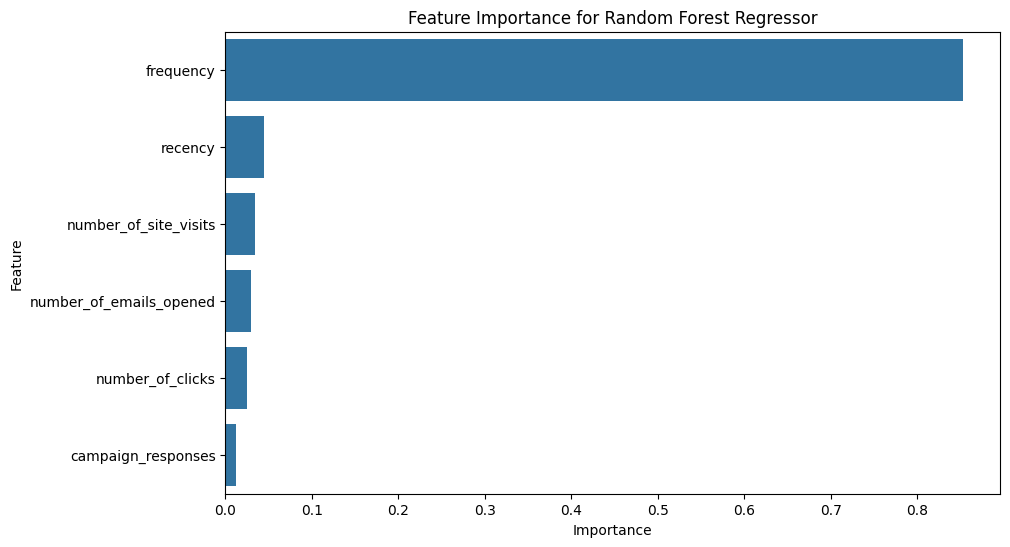

In [45]:
# Create a DataFrame for visualization
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances}).sort_values(by='Importance', ascending=False)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='Importance', y='Feature')
plt.title('Feature Importance for Random Forest Regressor')
plt.show()

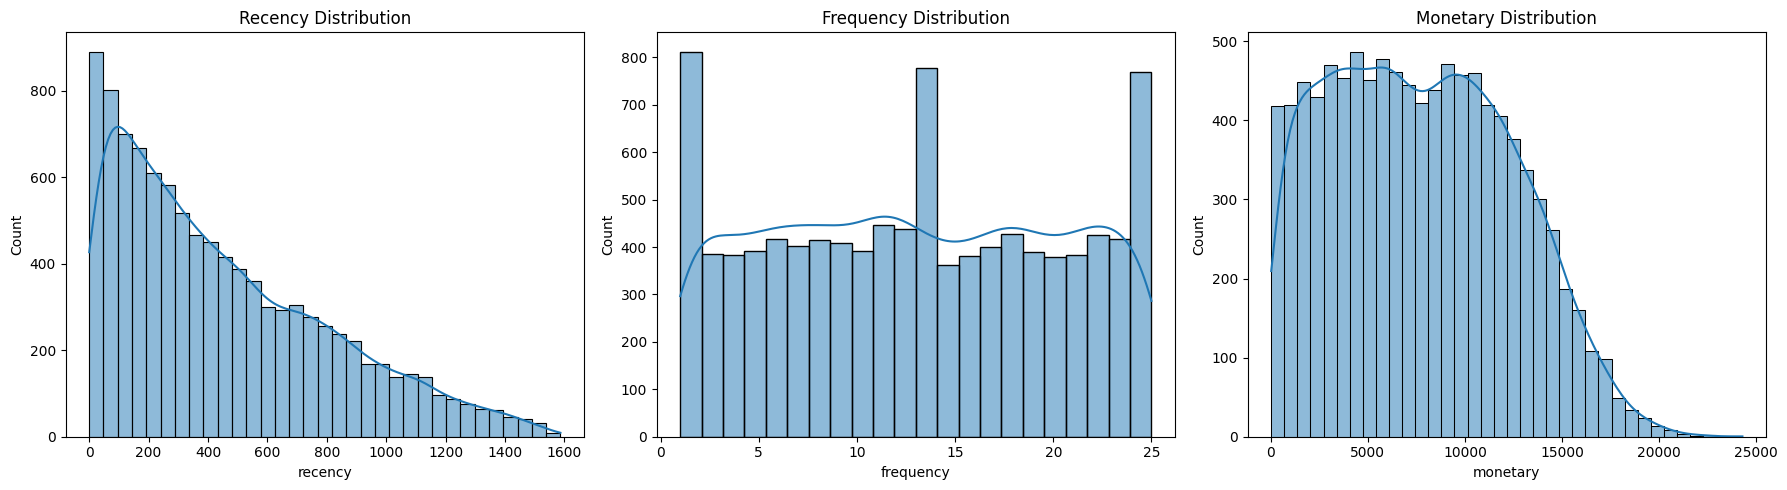

In [46]:
# Visualize Recency, Frequency, and Monetary Distributions
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.histplot(final_data['recency'], kde=True)
plt.title('Recency Distribution')

plt.subplot(1, 3, 2)
sns.histplot(final_data['frequency'], kde=True)
plt.title('Frequency Distribution')

plt.subplot(1, 3, 3)
sns.histplot(final_data['monetary'], kde=True)
plt.title('Monetary Distribution')

plt.tight_layout()
plt.show()

In [47]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split

In [48]:
#Define the parameter grid
#param_grid = {
    #'n_estimators': [50, 100, 200],
    #'max_depth': [None, 10, 20, 30],
    #'min_samples_split': [2, 5, 10],
    #'min_samples_leaf': [1, 2, 4],
    #'max_features': ['auto', 'sqrt', 'log2'],
    #'bootstrap': [True, False]
#}

In [49]:
# Prepare the data for modeling
#X = final_data.drop(columns=['customer_id', 'monetary'])
#y = final_data['monetary']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the RandomForestRegressor
#rf = RandomForestRegressor(random_state=42)

In [50]:
# Initialize GridSearchCV
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           #cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')

In [1]:
# Fit GridSearchCV
#grid_search.fit(X_train, y_train)

In [52]:
# Get the best parameters
#best_params = grid_search.best_params_
#print(f"Best parameters: {best_params}")

Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 200}


In [53]:
# SIMPLYFYING GRID SEARCH

# Prepare the data for modeling
#X = final_data.drop(columns=['customer_id', 'monetary'])
#y = final_data['monetary']

# Split the data into training and testing sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a simplified parameter grid
#param_grid = {
    #'n_estimators': [50, 100],  # Reduced range
    #'max_depth': [None, 10],  # Reduced range
    #'min_samples_split': [2, 5],
    #'min_samples_leaf': [1, 2],
    #'max_features': ['auto', 'sqrt'],
    #'bootstrap': [True, False]
#}

# Initialize the RandomForestRegressor
#rf = RandomForestRegressor(random_state=42)

# Initialize GridSearchCV
#grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           #cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error')


In [2]:
# Fit GridSearchCV
#grid_search.fit(X_train, y_train)

In [55]:
# Get the best parameters
#best_params = grid_search.best_params_
#print(f"Best parameters: {best_params}")

Best parameters: {'bootstrap': True, 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}


In [56]:
# RANDOMIZED SEARCH (since its more efficient than grid search)

from sklearn.model_selection import RandomizedSearchCV

# Define the parameter grid with a larger range
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

In [57]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, 
                                   n_iter=50, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error', random_state=42)


In [58]:
# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=20, max_features=log2, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   3.0s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=5, n_estimators=200; total time=   6.9s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=30, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=200; total time=   0.0s
[CV] END bootstrap=False, max_depth=10, max_features=auto, min_samples_leaf=4, min_samples_split=10, n_estimators=5

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
48 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
48 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-pac

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [59]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split

# Prepare the data for modeling
X = final_data.drop(columns=['customer_id', 'monetary'])
y = final_data['monetary']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the corrected parameter grid
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],  # Removed 'auto'
    'bootstrap': [True, False]
}

# Initialize the RandomForestRegressor
rf = RandomForestRegressor(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_distributions, 
                                   n_iter=50, cv=3, n_jobs=-1, verbose=2, scoring='neg_mean_squared_error', random_state=42)


# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   1.0s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=True, max_depth=10, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=50; total time=   0.8s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END bootstrap=False, max_depth=30, max_features=log2, min_samples_leaf=4, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=30, max_features=sqrt, min_samples_leaf=4, min_samples_split=2, n_estimators=50; total 

RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [None, 10, 20, 30],
                                        'max_features': ['sqrt', 'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [60]:
# Get the best parameters
best_params = random_search.best_params_
print(f"Best parameters: {best_params}")


Best parameters: {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}


In [61]:
# Train the Random Forest model with the best parameters
best_rf = random_search.best_estimator_

# Predict on training data
y_train_pred = best_rf.predict(X_train)

# Predict on testing data
y_test_pred = best_rf.predict(X_test)

# Evaluate model performance
train_mae = mean_absolute_error(y_train, y_train_pred)
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
train_r2 = r2_score(y_train, y_train_pred)

test_mae = mean_absolute_error(y_test, y_test_pred)
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print("Random Forest Training Performance with Best Parameters:")
print(f"MAE: {train_mae}, RMSE: {train_rmse}, R²: {train_r2}")

print("Random Forest Testing Performance with Best Parameters:")
print(f"MAE: {test_mae}, RMSE: {test_rmse}, R²: {test_r2}")


Random Forest Training Performance with Best Parameters:
MAE: 955.7361201651431, RMSE: 1246.5133651551682, R²: 0.9280665934174084
Random Forest Testing Performance with Best Parameters:
MAE: 1353.9263554269937, RMSE: 1770.5390859456045, R²: 0.848675996292942
